In [3]:
# Block 1: Dataset Preparation and Validation
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import random

class DatasetPreparer:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.images_path = self.dataset_path / "images"
        self.labels_path = self.dataset_path / "label"

    def validate_dataset(self):
        """Validate that images and corresponding annotation files exist"""
        print("🔍 Validating dataset...")

        image_files = list(self.images_path.glob("*.png")) + list(self.images_path.glob("*.jpg")) + list(self.images_path.glob("*.jpeg")) + list(self.images_path.glob("*.JPG"))
        label_files = list(self.labels_path.glob("*.txt"))

        print(f"Found {len(image_files)} images")
        print(f"Found {len(label_files)} label files")

        # Check for matching pairs
        image_names = {f.stem for f in image_files}
        label_names = {f.stem for f in label_files}

        missing_labels = image_names - label_names
        missing_images = label_names - image_names

        if missing_labels:
            print(f"⚠️ Images without labels: {len(missing_labels)}")
        if missing_images:
            print(f"⚠️ Labels without images: {len(missing_images)}")

        valid_pairs = image_names & label_names
        print(f"✅ Valid image-label pairs: {len(valid_pairs)}")

        return list(valid_pairs)

    def visualize_annotations(self, num_samples=5):
        """Visualize sample images with bounding boxes"""
        valid_pairs = self.validate_dataset()
        samples = random.sample(valid_pairs, min(num_samples, len(valid_pairs)))

        fig, axes = plt.subplots(1, len(samples), figsize=(15, 3))
        if len(samples) == 1:
            axes = [axes]

        for idx, sample_name in enumerate(samples):
            # Load image
            img_path = self.images_path / f"{sample_name}.png"
            if not img_path.exists():
                img_path = self.images_path / f"{sample_name}.jpg"

            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            h, w = image.shape[:2]

            # Load annotations
            label_path = self.labels_path / f"{sample_name}.txt"
            with open(label_path, 'r') as f:
                annotations = f.readlines()

            # Draw bounding boxes
            for annotation in annotations:
                parts = annotation.strip().split()
                if len(parts) >= 5:
                    class_id, x_center, y_center, width, height = map(float, parts[:5])

                    # Convert normalized coordinates to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h

                    # Calculate corner coordinates
                    x1 = int(x_center - width/2)
                    y1 = int(y_center - height/2)
                    x2 = int(x_center + width/2)
                    y2 = int(y_center + height/2)

                    # Draw rectangle
                    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(image, f'LP', (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            axes[idx].imshow(image)
            axes[idx].set_title(f"{sample_name}")
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

    def create_yolo_structure(self, output_path, train_ratio=0.8, val_ratio=0.1):
        """Create YOLO-compatible folder structure and split dataset"""
        output_path = Path(output_path)

        # Create directory structure
        for split in ['train', 'val', 'test']:
            (output_path / split / 'images').mkdir(parents=True, exist_ok=True)
            (output_path / split / 'labels').mkdir(parents=True, exist_ok=True)

        # Get valid pairs and shuffle
        valid_pairs = self.validate_dataset()
        random.shuffle(valid_pairs)

        # Calculate split indices
        total = len(valid_pairs)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        splits = {
            'train': valid_pairs[:train_end],
            'val': valid_pairs[train_end:val_end],
            'test': valid_pairs[val_end:]
        }

        print("📁 Creating YOLO dataset structure...")
        for split_name, file_names in splits.items():
            print(f"  {split_name}: {len(file_names)} files")

            for file_name in file_names:
                # Copy image
                img_src = self.images_path / f"{file_name}.png"
                if not img_src.exists():
                    img_src = self.images_path / f"{file_name}.jpg"

                if not img_src.exists():
                    img_src = self.images_path / f"{file_name}.jpeg"

                if not img_src.exists():
                    img_src = self.images_path / f"{file_name}.JPG"

                if not img_src.exists():
                    print(f"❌ Image not found: {img_src}")
                    continue
                img_dst = output_path / split_name / 'images' / img_src.name
                shutil.copy2(img_src, img_dst)

                # Copy label
                label_src = self.labels_path / f"{file_name}.txt"
                label_dst = output_path / split_name / 'labels' / f"{file_name}.txt"
                shutil.copy2(label_src, label_dst)

        # Create data.yaml file
        yaml_content = f"""
path: {output_path.absolute()}
train: train/images
val: val/images
test: test/images

nc: 1
names: ['license_plate']
"""

        with open(output_path / 'data.yaml', 'w') as f:
            f.write(yaml_content.strip())

        print(f"✅ Dataset prepared at: {output_path}")
        print(f"📄 Configuration saved as: {output_path}/data.yaml")

        return output_path


# Initialize dataset preparer
preparer = DatasetPreparer("/content/drive/MyDrive/datasets/test-yolo-2-4-annotations")  # Replace with your dataset path

# Validate and visualize
preparer.validate_dataset()
#preparer.visualize_annotations(num_samples=3)

# Create YOLO-compatible structure
yolo_dataset_path = preparer.create_yolo_structure("./bd_license_plate_yolo")

🔍 Validating dataset...
Found 785 images
Found 785 label files
✅ Valid image-label pairs: 785
🔍 Validating dataset...
Found 785 images
Found 785 label files
✅ Valid image-label pairs: 785
📁 Creating YOLO dataset structure...
  train: 628 files
  val: 78 files
  test: 79 files
✅ Dataset prepared at: bd_license_plate_yolo
📄 Configuration saved as: bd_license_plate_yolo/data.yaml


In [4]:
# Install the ultralytics library
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 Using device: cuda
🎯 Starting YOLOv8 training...


100%|██████████| 21.5M/21.5M [00:00<00:00, 187MB/s]


Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./bd_license_plate_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_bd_plates, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.

100%|██████████| 755k/755k [00:00<00:00, 18.8MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

 16                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 19                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1   1969152  ultralytics.nn.modules.block.C2f             [768, 512, 1]                 
 22        [15, 18, 21]  1   2116435  ultralytics.nn.modules.head.Detect           [1, [128, 256, 512]]          
Model summary: 129 layers, 11,135,987 parameters, 11,135,971 gradients, 28.6 GFLOPs

Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mi

100%|██████████| 5.35M/5.35M [00:00<00:00, 100MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 29.8±15.6 MB/s, size: 56.2 KB)


train: Scanning /content/bd_license_plate_yolo/train/labels... 672 images, 0 backgrounds, 0 corrupt: 100%|██████████| 672/672 [00:01<00:00, 435.51it/s]

train: New cache created: /content/bd_license_plate_yolo/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.1 ms, read: 27.2±5.9 MB/s, size: 108.1 KB)


val: Scanning /content/bd_license_plate_yolo/val/labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<00:00, 378.44it/s]

val: New cache created: /content/bd_license_plate_yolo/val/labels.cache


Plotting labels to bd_license_plate_training/yolov8_bd_plates/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to bd_license_plate_training/yolov8_bd_plates
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.52G      1.619      3.075      1.511         34        640: 100%|██████████| 42/42 [00:25<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

                   all         84         84      0.815      0.821      0.858      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.68G      1.451      1.126      1.346         36        640: 100%|██████████| 42/42 [00:23<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         84         84      0.644      0.881       0.72      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.71G        1.5      1.045      1.403         28        640: 100%|██████████| 42/42 [00:22<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         84         84      0.151       0.69      0.138     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.75G      1.554       1.09      1.409         32        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         84         84      0.401       0.56      0.472      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.79G      1.475      0.968      1.364         29        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         84         84      0.792      0.881      0.873      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.82G      1.428     0.9339      1.357         36        640: 100%|██████████| 42/42 [00:22<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         84         84      0.835      0.881      0.924       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.86G      1.458     0.9342      1.356         32        640: 100%|██████████| 42/42 [00:23<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]

                   all         84         84      0.912      0.917      0.932      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.89G      1.399     0.8836      1.337         32        640: 100%|██████████| 42/42 [00:20<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         84         84      0.946      0.869      0.919      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.93G      1.413     0.8392      1.322         32        640: 100%|██████████| 42/42 [00:21<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         84         84      0.918      0.928      0.925      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.97G      1.396     0.8564      1.317         33        640: 100%|██████████| 42/42 [00:22<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         84         84      0.946      0.905      0.955      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         5G      1.393      0.799      1.307         34        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]

                   all         84         84      0.852      0.961      0.956       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.04G      1.405     0.7853      1.322         28        640: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         84         84      0.968      0.952      0.976        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.08G      1.371      0.788      1.312         37        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         84         84      0.941      0.929      0.964      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.11G      1.404     0.7532      1.312         28        640: 100%|██████████| 42/42 [00:22<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         84         84       0.93      0.964      0.956      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.15G      1.321     0.7412      1.296         31        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all         84         84       0.95      0.976      0.976      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.19G      1.392     0.7763       1.34         35        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.35it/s]

                   all         84         84      0.938      0.976       0.97      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.22G       1.33     0.7361      1.296         36        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         84         84       0.97       0.94      0.979      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.26G      1.318     0.7178      1.282         36        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         84         84      0.959      0.929      0.979      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.29G      1.308      0.703      1.287         30        640: 100%|██████████| 42/42 [00:20<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         84         84      0.964          1       0.99      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.33G      1.306     0.7239      1.274         24        640: 100%|██████████| 42/42 [00:22<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

                   all         84         84      0.986      0.976       0.98      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.37G      1.256     0.6888      1.238         30        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         84         84      0.976      0.963      0.979      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       5.4G      1.305     0.7091      1.273         40        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         84         84      0.973      0.976      0.989       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.44G       1.32     0.6951      1.284         40        640: 100%|██████████| 42/42 [00:23<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]

                   all         84         84      0.954      0.998      0.973      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.48G      1.305     0.6911      1.274         27        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]

                   all         84         84      0.969      0.929      0.969      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.51G      1.266     0.6484       1.24         41        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         84         84      0.934      0.917      0.943      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.55G      1.262     0.6834      1.242         28        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]

                   all         84         84      0.969      0.952      0.976      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.59G      1.264     0.6402      1.263         29        640: 100%|██████████| 42/42 [00:21<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

                   all         84         84      0.975      0.988       0.99      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.62G      1.284     0.6444      1.262         31        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         84         84       0.97      0.976      0.994      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.66G      1.226     0.6174      1.232         26        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         84         84      0.973      0.976      0.984      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       5.7G      1.245     0.6138      1.237         34        640: 100%|██████████| 42/42 [00:22<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

                   all         84         84      0.965      0.964       0.98      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.73G      1.246     0.6407      1.239         34        640: 100%|██████████| 42/42 [00:20<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all         84         84      0.985      0.988      0.984      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.77G      1.205     0.6065      1.201         33        640: 100%|██████████| 42/42 [00:20<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         84         84      0.962      0.964      0.967      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       5.8G      1.239     0.6255      1.244         29        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         84         84      0.976      0.974      0.993      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.84G      1.207     0.6134      1.213         31        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]

                   all         84         84      0.975      0.988      0.992      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.88G      1.214     0.6219      1.212         30        640: 100%|██████████| 42/42 [00:21<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         84         84      0.955      0.999       0.99      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.91G      1.206     0.5989      1.192         28        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         84         84      0.988      0.973       0.99      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.95G      1.195      0.587      1.204         25        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]

                   all         84         84      0.977      0.988      0.992      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.99G      1.211     0.5998      1.221         28        640: 100%|██████████| 42/42 [00:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         84         84      0.985          1      0.994      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.02G       1.16     0.5676      1.197         25        640: 100%|██████████| 42/42 [00:21<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         84         84      0.987      0.988      0.993      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.06G      1.169     0.5926      1.181         28        640: 100%|██████████| 42/42 [00:21<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]

                   all         84         84      0.952      0.952      0.968        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       6.1G      1.146     0.5779      1.174         39        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         84         84      0.988      0.972      0.983      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.13G      1.158     0.5911      1.181         31        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         84         84      0.988      0.998      0.985      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.17G      1.125     0.5618      1.164         29        640: 100%|██████████| 42/42 [00:22<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         84         84      0.984          1      0.984      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.53G      1.135     0.5678      1.176         25        640: 100%|██████████| 42/42 [00:20<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         84         84      0.976      0.988      0.967      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.56G      1.138     0.5467      1.181         31        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         84         84      0.985      0.988      0.992      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       6.6G       1.11      0.544      1.164         35        640: 100%|██████████| 42/42 [00:21<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         84         84      0.973          1      0.993      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.64G      1.088     0.5313      1.142         22        640: 100%|██████████| 42/42 [00:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         84         84      0.976      0.973      0.983      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.67G        1.1     0.5513      1.154         31        640: 100%|██████████| 42/42 [00:21<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         84         84      0.979      0.976      0.988      0.583
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 28, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



48 epochs completed in 0.326 hours.
Optimizer stripped from bd_license_plate_training/yolov8_bd_plates/weights/last.pt, 22.5MB
Optimizer stripped from bd_license_plate_training/yolov8_bd_plates/weights/best.pt, 22.5MB

Validating bd_license_plate_training/yolov8_bd_plates/weights/best.pt...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


                   all         84         84       0.97      0.976      0.994      0.624
Speed: 0.4ms preprocess, 6.3ms inference, 0.0ms loss, 7.4ms postprocess per image
Results saved to bd_license_plate_training/yolov8_bd_plates
✅ Training completed!
📊 Evaluating model...
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1284.2±857.3 MB/s, size: 106.1 KB)


val: Scanning /content/bd_license_plate_yolo/val/labels.cache... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


                   all         84         84      0.971      0.976      0.994      0.622
Speed: 4.3ms preprocess, 14.6ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to bd_license_plate_training/yolov8_bd_plates2
📈 Evaluation Results:
  mAP50: 0.9937
  mAP50-95: 0.6215
  Precision: 0.9706
  Recall: 0.9762


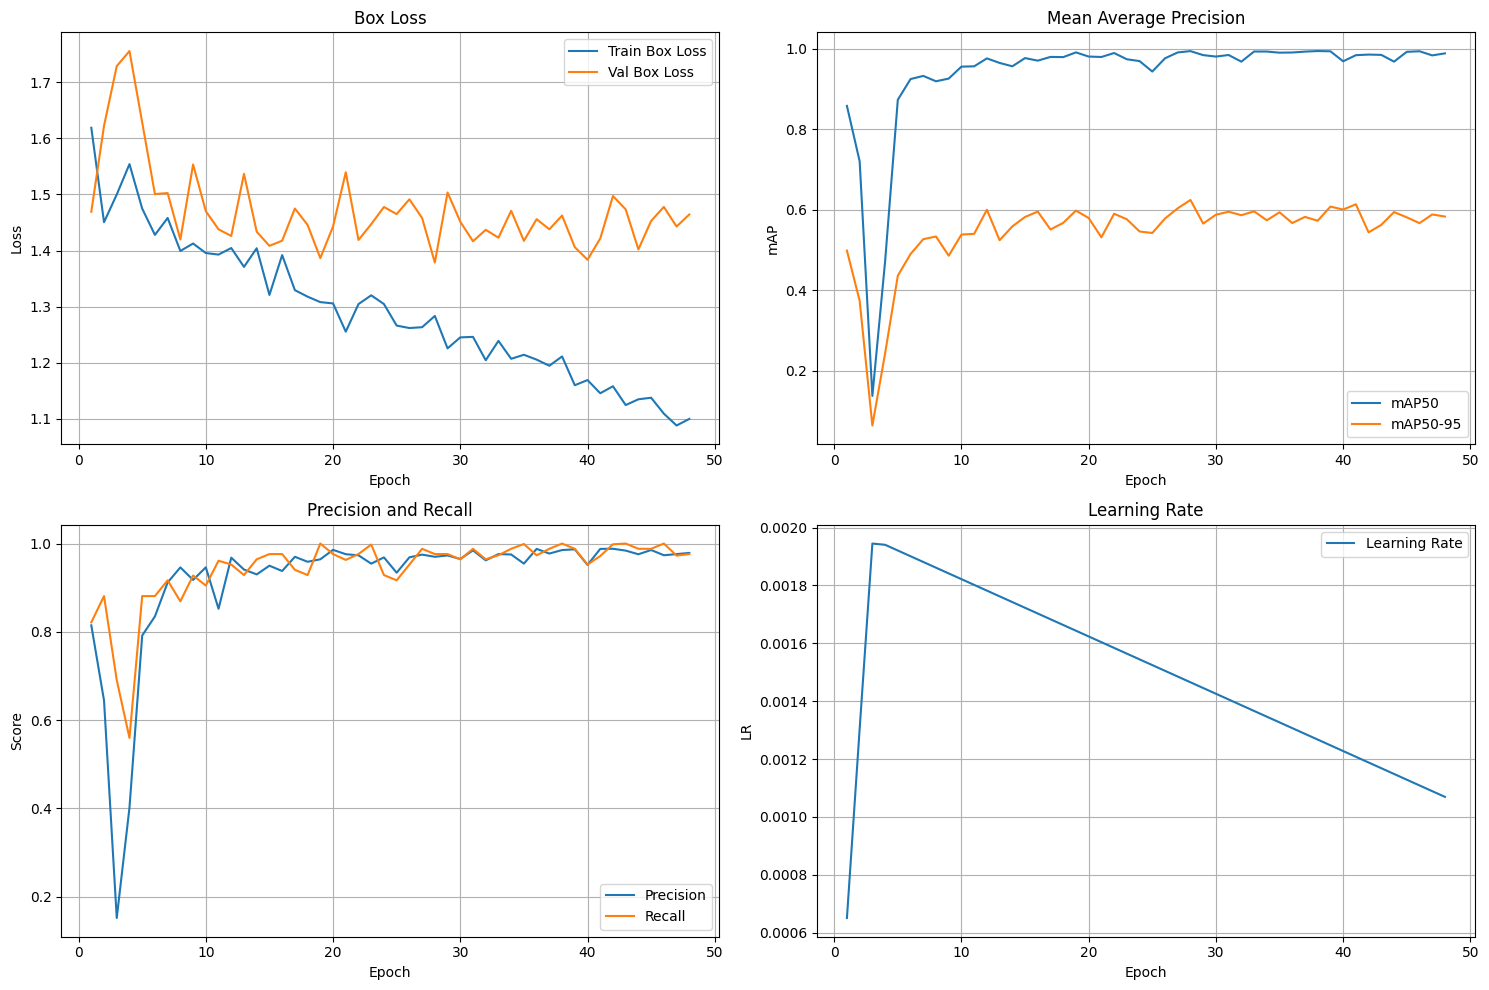

✅ Model saved as: bd_license_plate_detector.pt


In [5]:
# Block 2: YOLOv8 Training Module
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

class YOLOTrainer:
    def __init__(self, data_yaml_path, model_name='yolov8n.pt'):
        """
        Initialize YOLO trainer

        Args:
            data_yaml_path: Path to data.yaml file
            model_name: Pre-trained model to use (yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, yolov8x.pt)
        """
        self.data_yaml_path = data_yaml_path
        self.model_name = model_name
        self.model = None
        self.results = None

        # Check if CUDA is available
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"🚀 Using device: {self.device}")

    def train_model(self, epochs=100, imgsz=640, batch_size=16, patience=50):
        """
        Train YOLOv8 model for license plate detection

        Args:
            epochs: Number of training epochs
            imgsz: Image size for training
            batch_size: Batch size for training
            patience: Early stopping patience
        """
        print("🎯 Starting YOLOv8 training...")

        # Load pre-trained model
        self.model = YOLO(self.model_name)

        # Train the model
        self.results = self.model.train(
            data=self.data_yaml_path,
            epochs=epochs,
            imgsz=imgsz,
            batch=batch_size,
            patience=patience,
            device=self.device,
            project='bd_license_plate_training',
            name='yolov8_bd_plates',
            save=True,
            plots=True,
            verbose=True
        )

        print("✅ Training completed!")
        return self.results

    def evaluate_model(self):
        """Evaluate the trained model on test set"""
        if self.model is None:
            print("❌ No trained model found. Train the model first.")
            return None

        print("📊 Evaluating model...")

        # Validate on test set
        metrics = self.model.val()

        print(f"📈 Evaluation Results:")
        print(f"  mAP50: {metrics.box.map50:.4f}")
        print(f"  mAP50-95: {metrics.box.map:.4f}")
        print(f"  Precision: {metrics.box.mp:.4f}")
        print(f"  Recall: {metrics.box.mr:.4f}")

        return metrics

    def plot_training_results(self, save_path=None):
        """Plot training metrics"""
        try:
            # Read results from CSV file
            results_dir = Path('bd_license_plate_training/yolov8_bd_plates')
            results_csv = results_dir / 'results.csv'

            if results_csv.exists():
                df = pd.read_csv(results_csv)
                df.columns = df.columns.str.strip()  # Remove extra spaces

                fig, axes = plt.subplots(2, 2, figsize=(15, 10))

                # Plot training and validation loss
                if 'train/box_loss' in df.columns:
                    axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
                    axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
                    axes[0, 0].set_title('Box Loss')
                    axes[0, 0].set_xlabel('Epoch')
                    axes[0, 0].set_ylabel('Loss')
                    axes[0, 0].legend()
                    axes[0, 0].grid(True)

                # Plot mAP
                if 'metrics/mAP50(B)' in df.columns:
                    axes[0, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
                    axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
                    axes[0, 1].set_title('Mean Average Precision')
                    axes[0, 1].set_xlabel('Epoch')
                    axes[0, 1].set_ylabel('mAP')
                    axes[0, 1].legend()
                    axes[0, 1].grid(True)

                # Plot Precision and Recall
                if 'metrics/precision(B)' in df.columns:
                    axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
                    axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
                    axes[1, 0].set_title('Precision and Recall')
                    axes[1, 0].set_xlabel('Epoch')
                    axes[1, 0].set_ylabel('Score')
                    axes[1, 0].legend()
                    axes[1, 0].grid(True)

                # Plot Learning Rate
                if 'lr/pg0' in df.columns:
                    axes[1, 1].plot(df['epoch'], df['lr/pg0'], label='Learning Rate')
                    axes[1, 1].set_title('Learning Rate')
                    axes[1, 1].set_xlabel('Epoch')
                    axes[1, 1].set_ylabel('LR')
                    axes[1, 1].legend()
                    axes[1, 1].grid(True)

                plt.tight_layout()

                if save_path:
                    plt.savefig(save_path, dpi=300, bbox_inches='tight')

                plt.show()
            else:
                print("❌ Results CSV file not found")

        except Exception as e:
            print(f"❌ Error plotting results: {e}")

    def save_model(self, save_path="bd_license_plate_best.pt"):
        """Save the trained model"""
        if self.model is None:
            print("❌ No trained model to save")
            return None

        # The best model is automatically saved during training
        best_model_path = Path('bd_license_plate_training/yolov8_bd_plates/weights/best.pt')

        if best_model_path.exists():
            import shutil
            shutil.copy2(best_model_path, save_path)
            print(f"✅ Model saved as: {save_path}")
        else:
            print("❌ Best model weights not found")

        return save_path

    def test_single_image(self, image_path, conf_threshold=0.25):
        """Test the model on a single image"""
        if self.model is None:
            print("❌ No trained model found")
            return None

        # Run inference
        results = self.model(image_path, conf=conf_threshold)

        # Display results
        for r in results:
            r.show()  # Display image with predictions

        return results

# Initialize trainer
trainer = YOLOTrainer(
    data_yaml_path="./bd_license_plate_yolo/data.yaml",
    model_name='yolov8s.pt'  # Start with nano model for faster training
)

# Train model (adjust parameters based on your needs)
training_results = trainer.train_model(
    epochs=100,
    imgsz=640,
    batch_size=16,
    patience=20
)

# Evaluate model
evaluation_metrics = trainer.evaluate_model()

# Plot training results
trainer.plot_training_results()

# Save the best model
model_path = trainer.save_model("bd_license_plate_detector.pt")

In [6]:
# Install easyocr
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 26.8 MB/s eta 0:00:00


In [7]:
# Block 3: OCR Module for License Plate Text Recognition
import cv2
import numpy as np
import easyocr
import re
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

class LicensePlateOCR:
    def __init__(self, languages=['bn']):
        """
        Initialize OCR reader for Bengali license plates

        Args:
            languages: List of languages for OCR ('en' for English, 'bn' for Bengali)
        """
        print("🔤 Initializing OCR reader...")
        self.reader = easyocr.Reader(languages, gpu=True)
        print("✅ OCR reader initialized")

    def preprocess_plate_image(self, plate_image):
        """
        Preprocess cropped license plate image for better OCR

        Args:
            plate_image: Cropped license plate image (numpy array)
        """
        # Convert to PIL Image for enhancement
        if isinstance(plate_image, np.ndarray):
            plate_pil = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
        else:
            plate_pil = plate_image

        # Enhance contrast
        enhancer = ImageEnhance.Contrast(plate_pil)
        plate_pil = enhancer.enhance(2.0)

        # Enhance sharpness
        enhancer = ImageEnhance.Sharpness(plate_pil)
        plate_pil = enhancer.enhance(2.0)

        # Convert back to opencv format
        enhanced = cv2.cvtColor(np.array(plate_pil), cv2.COLOR_RGB2BGR)

        # Convert to grayscale
        gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )

        # Morphological operations to clean up
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Resize for better OCR (if too small)
        height, width = cleaned.shape
        if height < 50 or width < 150:
            scale_factor = max(50/height, 150/width)
            new_width = int(width * scale_factor)
            new_height = int(height * scale_factor)
            cleaned = cv2.resize(cleaned, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

        return cleaned

    def extract_text_from_plate(self, plate_image, visualize=False):
        """
        Extract text from license plate image

        Args:
            plate_image: Cropped license plate image
            visualize: Whether to show preprocessing steps
        """
        # Preprocess the image
        processed_image = self.preprocess_plate_image(plate_image)

        if visualize:
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original Plate')
            axes[0].axis('off')

            axes[1].imshow(processed_image, cmap='gray')
            axes[1].set_title('Processed for OCR')
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

        # Perform OCR
        try:
            results = self.reader.readtext(processed_image)

            if not results:
                # Try with original image if preprocessing failed
                results = self.reader.readtext(plate_image)

            # Extract text with confidence
            extracted_texts = []
            for (bbox, text, confidence) in results:
                if confidence > 0.5:  # Filter low confidence results
                    extracted_texts.append({
                        'text': text.strip(),
                        'confidence': confidence,
                        'bbox': bbox
                    })

            return extracted_texts

        except Exception as e:
            print(f"❌ OCR Error: {e}")
            return []

    def format_bd_license_plate(self, raw_texts):
        """
        Format and validate Bangladeshi license plate patterns

        Common BD formats:
        - Dhaka Metro: ঢাকা মেট্রো গ-১২-৩৪৫৬
        - City format: ঢাকা-গ-১২-৩৪৫৬
        - General: [City]-[Letter]-[Numbers]
        """
        if not raw_texts:
            return None

        # Combine all text
        combined_text = ' '.join([item['text'] for item in raw_texts])

        # Clean up text
        cleaned_text = re.sub(r'[^\u0980-\u09FF\w\s\-]', '', combined_text)

        # Basic validation patterns for BD plates
        patterns = [
            r'[\u0980-\u09FF\w\s]+-[\u0980-\u09FF]+-\d+-\d+',  # City-Letter-Numbers
            r'[\u0980-\u09FF\w\s]+\s+[\u0980-\u09FF]+\s*\d+\s*\d+',  # City Letter Numbers
        ]

        result = {
            'raw_text': combined_text,
            'cleaned_text': cleaned_text,
            'confidence': np.mean([item['confidence'] for item in raw_texts]),
            'individual_texts': raw_texts,
            'is_valid_format': False
        }

        # Check against patterns
        for pattern in patterns:
            if re.search(pattern, cleaned_text):
                result['is_valid_format'] = True
                break

        return result

    def recognize_license_plate(self, plate_image, visualize=False):
        """
        Complete pipeline to recognize license plate text

        Args:
            plate_image: Cropped license plate image
            visualize: Whether to show processing steps
        """
        # Extract text using OCR
        raw_texts = self.extract_text_from_plate(plate_image, visualize)

        if not raw_texts:
            return {
                'success': False,
                'message': 'No text detected',
                'result': None
            }

        # Format and validate
        formatted_result = self.format_bd_license_plate(raw_texts)

        return {
            'success': True,
            'message': 'Text recognized successfully',
            'result': formatted_result
        }

# Enhanced OCR with multiple preprocessing strategies
class AdvancedBDPlateOCR(LicensePlateOCR):
    def __init__(self):
        super().__init__(languages=['en', 'bn'])

    def multi_preprocess_ocr(self, plate_image):
        """
        Try multiple preprocessing strategies and combine results
        """
        strategies = [
            self.preprocess_plate_image,
            self.preprocess_strategy_2,
            self.preprocess_strategy_3
        ]

        all_results = []

        for strategy in strategies:
            try:
                processed = strategy(plate_image)
                results = self.reader.readtext(processed)

                for (bbox, text, confidence) in results:
                    if confidence > 0.3:
                        all_results.append({
                            'text': text.strip(),
                            'confidence': confidence,
                            'bbox': bbox,
                            'strategy': strategy.__name__
                        })
            except:
                continue

        # Remove duplicates and pick best results
        unique_results = {}
        for result in all_results:
            text = result['text']
            if text not in unique_results or result['confidence'] > unique_results[text]['confidence']:
                unique_results[text] = result

        return list(unique_results.values())

    def preprocess_strategy_2(self, plate_image):
        """Alternative preprocessing strategy"""
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

        # Apply bilateral filter to reduce noise while keeping edges sharp
        filtered = cv2.bilateralFilter(gray, 11, 17, 17)

        # Apply OTSU thresholding
        _, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return thresh

    def preprocess_strategy_3(self, plate_image):
        """Another alternative preprocessing strategy"""
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

        # Apply histogram equalization
        equalized = cv2.equalizeHist(gray)

        # Apply morphological opening
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        opened = cv2.morphologyEx(equalized, cv2.MORPH_OPEN, kernel)

        return opened


ocr = LicensePlateOCR()

🔤 Initializing OCR reader...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete✅ OCR reader initialized


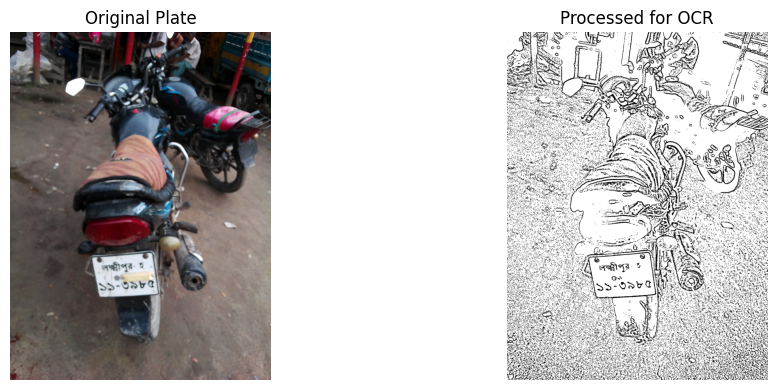

Recognition Result: {'raw_text': '১৯-৯৮০', 'cleaned_text': '১৯-৯৮০', 'confidence': np.float64(0.5374774128137816), 'individual_texts': [{'text': '১৯-৯৮০', 'confidence': np.float64(0.5374774128137816), 'bbox': [[np.int32(522), np.int32(1450)], [np.int32(859), np.int32(1450)], [np.int32(859), np.int32(1534)], [np.int32(522), np.int32(1534)]]}], 'is_valid_format': False}


In [15]:
plate_image = cv2.imread("/content/drive/MyDrive/datasets/test-yolo-1-4-annonations/images/Vehicle169.jpg")  # Replace with actual image
result = ocr.recognize_license_plate(plate_image, visualize=True)

if result['success']:
    print("Recognition Result:", result['result'])
else:
    print("Recognition failed:", result['message'])

In [9]:
# Block 4: Complete License Plate Detection and Recognition Pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
import time
import json

class BDLicensePlateSystem:
    def __init__(self, yolo_model_path, confidence_threshold=0.25):
        """
        Complete system for detecting and recognizing Bangladeshi license plates

        Args:
            yolo_model_path: Path to trained YOLO model
            confidence_threshold: Minimum confidence for detections
        """
        print("🚀 Initializing BD License Plate System...")

        # Load YOLO model
        self.yolo_model = YOLO(yolo_model_path)
        self.confidence_threshold = confidence_threshold

        # Initialize OCR
        from easyocr import Reader
        self.ocr_reader = Reader(['en', 'bn'], gpu=True)

        print("✅ System initialized successfully!")

    def detect_license_plates(self, image):
        """
        Detect license plates in an image using YOLO

        Args:
            image: Input image (numpy array or path)

        Returns:
            List of detected plate regions with coordinates
        """
        # Run YOLO inference
        results = self.yolo_model(image, conf=self.confidence_threshold)

        detected_plates = []

        for r in results:
            boxes = r.boxes
            if boxes is not None:
                for box in boxes:
                    # Get coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = box.conf[0].cpu().numpy()

                    detected_plates.append({
                        'bbox': [int(x1), int(y1), int(x2), int(y2)],
                        'confidence': float(confidence)
                    })

        return detected_plates

    def crop_license_plate(self, image, bbox, padding=10):
        """
        Crop license plate region from image with padding

        Args:
            image: Original image
            bbox: Bounding box [x1, y1, x2, y2]
            padding: Padding around the plate
        """
        x1, y1, x2, y2 = bbox
        h, w = image.shape[:2]

        # Add padding
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(w, x2 + padding)
        y2 = min(h, y2 + padding)

        return image[y1:y2, x1:x2]

    def preprocess_plate_for_ocr(self, plate_image):
        """Enhanced preprocessing for Bengali plates"""
        # Convert to grayscale
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

        # Apply bilateral filter
        filtered = cv2.bilateralFilter(gray, 11, 17, 17)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
        )

        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        cleaned = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Resize if too small
        h, w = cleaned.shape
        if h < 50 or w < 150:
            scale = max(50/h, 150/w)
            new_h, new_w = int(h * scale), int(w * scale)
            cleaned = cv2.resize(cleaned, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        return cleaned

    def recognize_text(self, plate_image):
        """
        Recognize text from license plate image
        """
        # Preprocess image
        processed = self.preprocess_plate_for_ocr(plate_image)

        # Perform OCR
        try:
            results = self.ocr_reader.readtext(processed)

            # If no results, try with original image
            if not results:
                results = self.ocr_reader.readtext(plate_image)

            # Extract text with confidence
            extracted_texts = []
            for (bbox, text, confidence) in results:
                if confidence > 0.4:  # Filter low confidence
                    extracted_texts.append({
                        'text': text.strip(),
                        'confidence': confidence
                    })

            return extracted_texts

        except Exception as e:
            print(f"OCR Error: {e}")
            return []

    def process_single_image(self, image_path, visualize=True):
        """
        Complete pipeline for single image processing

        Args:
            image_path: Path to input image
            visualize: Whether to show results
        """
        # Load image
        image = cv2.imread(str(image_path))
        if image is None:
            return {"error": "Could not load image"}

        start_time = time.time()

        # Step 1: Detect license plates
        detected_plates = self.detect_license_plates(image)

        if not detected_plates:
            return {
                "success": False,
                "message": "No license plates detected",
                "processing_time": time.time() - start_time
            }

        # Step 2: Process each detected plate
        results = []

        for i, plate_info in enumerate(detected_plates):
            bbox = plate_info['bbox']
            detection_conf = plate_info['confidence']

            # Crop plate region
            cropped_plate = self.crop_license_plate(image, bbox)

            # Recognize text
            ocr_results = self.recognize_text(cropped_plate)

            # Combine text
            combined_text = ' '.join([item['text'] for item in ocr_results])
            avg_confidence = np.mean([item['confidence'] for item in ocr_results]) if ocr_results else 0

            results.append({
                'plate_id': i + 1,
                'bbox': bbox,
                'detection_confidence': detection_conf,
                'recognized_text': combined_text,
                'ocr_confidence': avg_confidence,
                'individual_texts': ocr_results
            })

        processing_time = time.time() - start_time

        # Visualize results
        if visualize:
            self.visualize_results(image, results)

        return {
            "success": True,
            "image_path": str(image_path),
            "num_plates_detected": len(results),
            "results": results,
            "processing_time": processing_time
        }

    def visualize_results(self, image, results):
        """
        Visualize detection and recognition results
        """
        # Create a copy for visualization
        vis_image = image.copy()

        # Draw bounding boxes and text
        for result in results:
            bbox = result['bbox']
            text = result['recognized_text']
            det_conf = result['detection_confidence']
            ocr_conf = result['ocr_confidence']

            x1, y1, x2, y2 = bbox

            # Draw bounding box
            cv2.rectangle(vis_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Prepare label
            label = f"Plate {result['plate_id']}: {text}"
            conf_label = f"Det: {det_conf:.2f}, OCR: {ocr_conf:.2f}"

            # Draw labels
            cv2.putText(vis_image, label, (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            cv2.putText(vis_image, conf_label, (x1, y2+20),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Display result
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
        plt.title("License Plate Detection and Recognition Results")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def process_video(self, video_path, output_path=None, max_frames=None):
        """
        Process video for license plate detection

        Args:
            video_path: Path to input video
            output_path: Path to save output video
            max_frames: Maximum frames to process (None for all)
        """
        cap = cv2.VideoCapture(str(video_path))

        if not cap.isOpened():
            return {"error": "Could not open video"}

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Setup video writer if output path provided
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        all_results = []

        print(f"Processing video: {total_frames} frames at {fps} FPS")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            if max_frames and frame_count >= max_frames:
                break

            # Process frame
            detected_plates = self.detect_license_plates(frame)

            # Draw results on frame
            for plate_info in detected_plates:
                bbox = plate_info['bbox']
                conf = plate_info['confidence']

                x1, y1, x2, y2 = bbox
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f"Plate: {conf:.2f}", (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

            # Save frame if output writer exists
            if output_path:
                out.write(frame)

            # Store results
            all_results.append({
                'frame': frame_count,
                'detections': detected_plates
            })

            frame_count += 1

            if frame_count % 30 == 0:  # Progress update every 30 frames
                print(f"Processed {frame_count}/{total_frames} frames")

        # Cleanup
        cap.release()
        if output_path:
            out.release()

        return {
            "success": True,
            "total_frames": frame_count,
            "results": all_results,
            "output_path": output_path
        }

    def batch_process_images(self, image_dir, output_file="batch_results.json"):
        """
        Process multiple images in a directory

        Args:
            image_dir: Directory containing images
            output_file: JSON file to save results
        """
        image_dir = Path(image_dir)
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

        # Find all images
        image_files = []
        for ext in image_extensions:
            image_files.extend(image_dir.glob(f"*{ext}"))
            image_files.extend(image_dir.glob(f"*{ext.upper()}"))

        print(f"Found {len(image_files)} images to process")

        all_results = []

        for i, image_path in enumerate(image_files):
            print(f"Processing {i+1}/{len(image_files)}: {image_path.name}")

            result = self.process_single_image(image_path, visualize=False)
            all_results.append(result)

        # Save results
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(all_results, f, indent=2, ensure_ascii=False)

        print(f"✅ Batch processing complete! Results saved to: {output_file}")

        # Summary statistics
        successful = sum(1 for r in all_results if r.get('success', False))
        total_plates = sum(r.get('num_plates_detected', 0) for r in all_results)
        avg_time = np.mean([r.get('processing_time', 0) for r in all_results])

        print(f"📊 Summary:")
        print(f"  Successful processes: {successful}/{len(image_files)}")
        print(f"  Total plates detected: {total_plates}")
        print(f"  Average processing time: {avg_time:.2f}s")

        return all_results




🚀 Initializing BD License Plate System...
✅ System initialized successfully!

0: 480x640 1 license_plate, 96.2ms
Speed: 2.2ms preprocess, 96.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


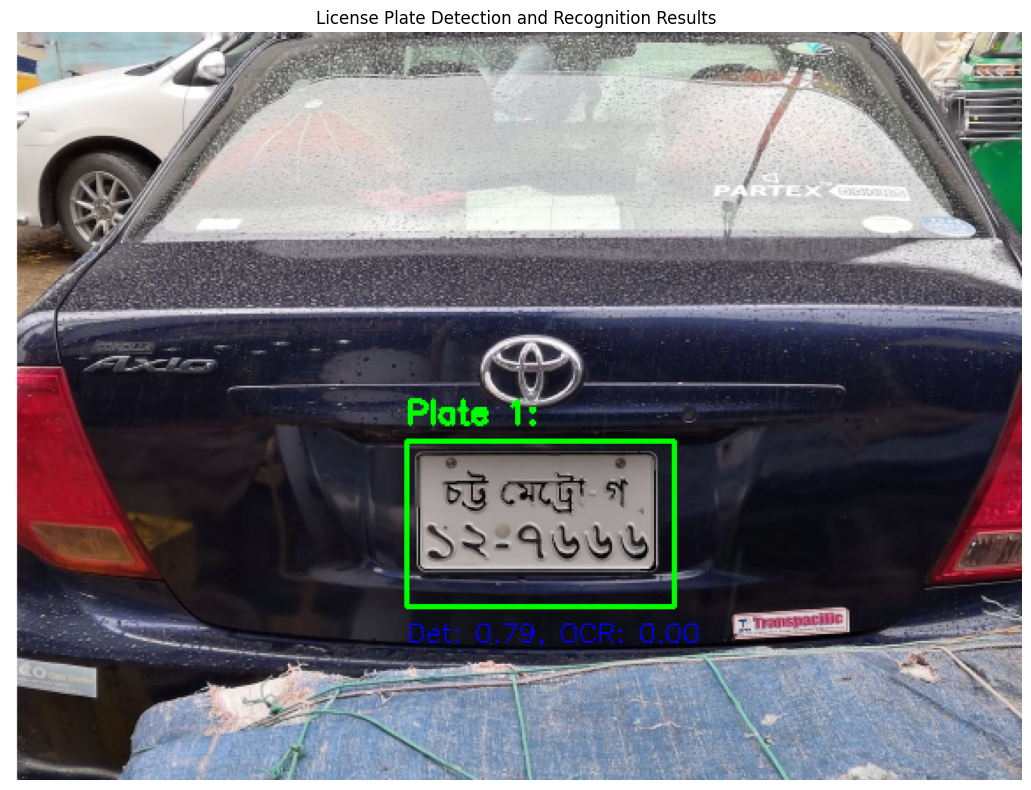

Single image result: {'success': True, 'image_path': '/content/drive/MyDrive/datasets/test-yolo-1-4-annonations/images/Vehicle1734.png', 'num_plates_detected': 1, 'results': [{'plate_id': 1, 'bbox': [225, 232, 377, 326], 'detection_confidence': 0.7850719094276428, 'recognized_text': '', 'ocr_confidence': 0, 'individual_texts': []}], 'processing_time': 0.33735084533691406}


In [26]:
# Initialize the complete system
system = BDLicensePlateSystem(
    yolo_model_path="bd_license_plate_detector.pt",  # Your trained model
    confidence_threshold=0.2
)

# Test on single image
result = system.process_single_image("/content/drive/MyDrive/datasets/test-yolo-1-4-annonations/images/Vehicle1734.png")
print("Single image result:", result)

# # Batch process images
# batch_results = system.batch_process_images("/content/drive/MyDrive/datasets/train-test-25/train")
# # print("Batch processing complete!")